# Прогнозирование уровня средней заработной платы в России

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox
import warnings

from datetime import datetime
from dateutil import relativedelta

from itertools import product
import matplotlib.pyplot as plt
import seaborn as sns

D:\Future\Anaconda\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


#### Обратное преобразование Бокса-Кокса

In [2]:
def invboxcox(y, lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

#### Данные о средней зарплате в РФ

In [3]:
data = pd.read_csv('zarplata.csv', ';', index_col=['month'], parse_dates=['month'], dayfirst=True)
data.columns = ['money']
data.head()

,money
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


## Часть 1. Визуальный анализ ряда.

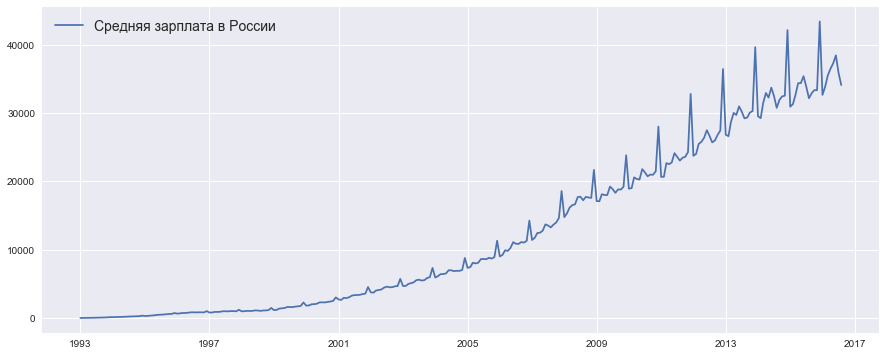

In [4]:
plt.figure(figsize=(15, 6))
plt.plot(data)
plt.legend(['Средняя зарплата в России'], fontsize=14, loc='upper left')
plt.show()

На графике мы видим:
* явный тренд
* усиливающиеся сезонные колебания
* __растущую дисперсию (необходима стабилизация)__
* ряд нестационарный

## Часть 2. Стабилизация дисперсии.

Для этого воспользуемся преобразованием __Бокса-Кокса__ и снова визуализируем временной ряд.

Оптимальный параметр преобразования Бокса-Кокса: 0.2632017541844584


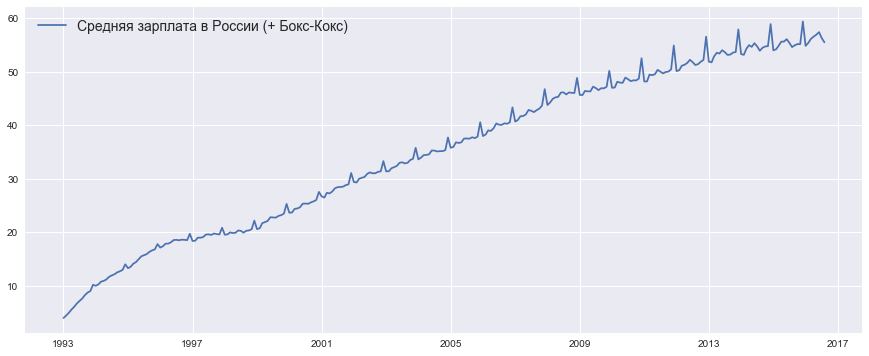

In [5]:
data['money_boxcox'], lmbda = stats.boxcox(data.money)
print("Оптимальный параметр преобразования Бокса-Кокса: {}".format(lmbda))
plt.figure(figsize=(15,6))
plt.plot(data.money_boxcox)
plt.legend(['Средняя зарплата в России (+ Бокс-Кокс)'], fontsize=14, loc='upper left')
plt.show()

* Мы серьезно уменьшили дисперсию

## Часть 3. Выбор порядка дифференцирования.
Нам нужно получить стационарный ряд, похожий на случайные колебания около нуля, в котором минимум структуры.

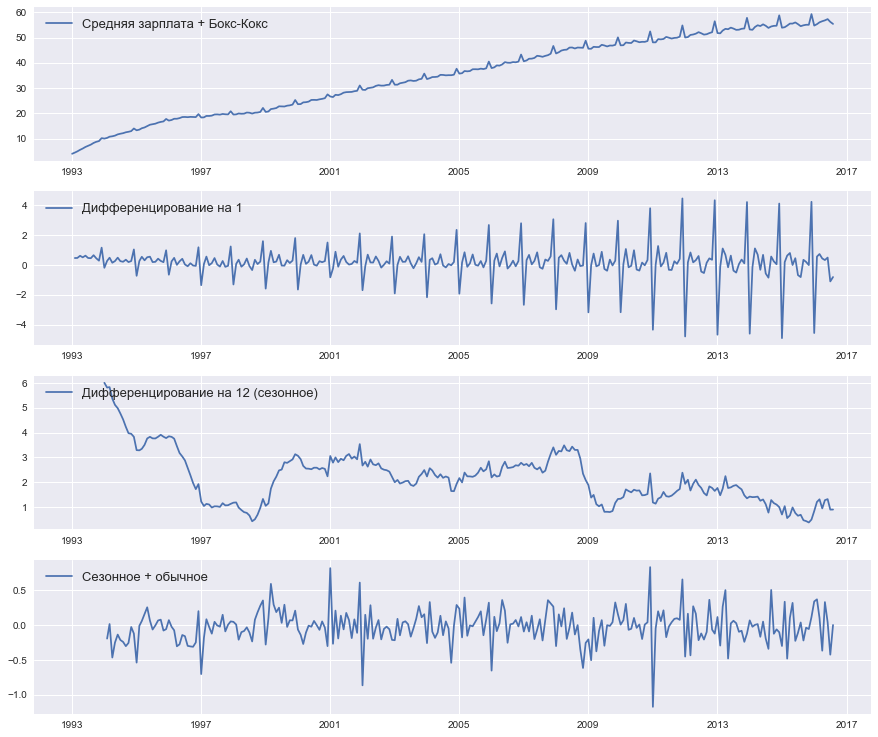

Критерий Дики-Фуллера (H0: ряд нестационарный) для нижнего графика: p_value=5.203603715821267e-08


In [6]:
diff1 = (data.money_boxcox - data.money_boxcox.shift(1)).dropna()
diff2 = (data.money_boxcox - data.money_boxcox.shift(12)).dropna()
diff3 = (diff2 - diff2.shift(1)).dropna()

plt.figure(figsize=(15, 13))
ax1 = plt.subplot(411)
plt.plot(data.money_boxcox)
plt.legend(['Средняя зарплата + Бокс-Кокс'], fontsize=13, loc='upper left')

ax2 = plt.subplot(412, sharex = ax1)
plt.plot(diff1)
plt.legend(['Дифференцирование на 1'], fontsize=13, loc='upper left')

ax3 = plt.subplot(413, sharex = ax1)
plt.plot(diff2)
plt.legend(['Дифференцирование на 12 (сезонное)'], fontsize=13, loc='upper left')

ax5 = plt.subplot(414, sharex = ax1)
plt.plot(diff3)
plt.legend(['Сезонное + обычное'], fontsize=13, loc='upper left')
plt.show()

dic_ful = sm.tsa.stattools.adfuller(diff3)[1]
print("Критерий Дики-Фуллера (H0: ряд нестационарный) для нижнего графика: p_value={}".format(dic_ful))

У нас есть тренд и сильные сезонные изменения, поэтому делаем сезонное дифференцирование.
После него все еще остается тренд и структура, делаем еще и обычное дифференцирование (со смещением 1)

Наилучшим образом под описание подходит последний график.
* тренда нет
* сезонности нет
* все хаотично и вокруг нуля

Наш порядок: __сезонное + обычное__

## Часть 4. Выбор начальных приближений для p, q, P, Q.
Строим автокорреляционные функции и __думаем__.

__На обычной автокоррелограмме:__
* q - номер последнего несезонного лага со значимой корреляцией
* Q - номер последнего сезонного лага со значимой корреляцией, деленный на 12 (сезон) 

__На частной/частичной автокоррелограмме:__
* p - номер последнего несезонного лага со значимой корреляцией
* P - номер последнего сезонного лага со значимой корреляцией, деленный на 12 (сезон) 

__Внимание светлым умам!__
Я до конца не понял как отличить сезонный от несезонного, как в целом эти приближения выбрать. Если кто пояснит - будет круто =)

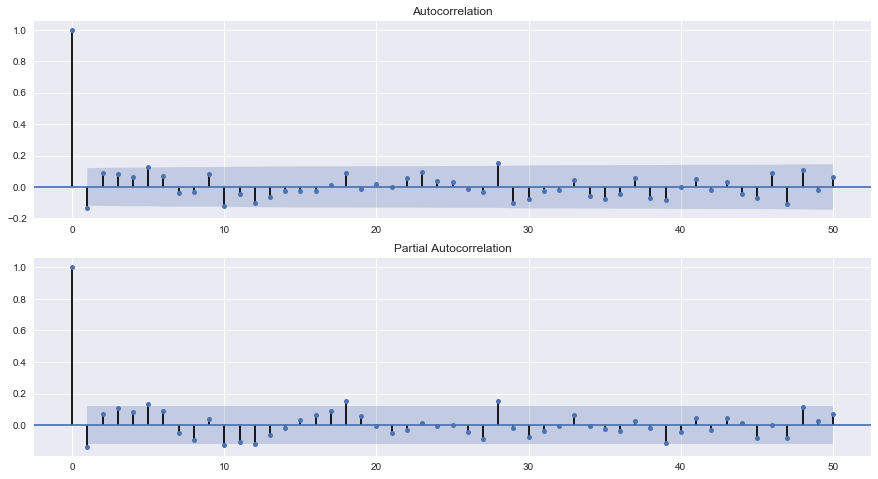

In [7]:
plt.figure(figsize=(15,8))
ax1 = plt.subplot(211)
sm.graphics.tsa.plot_acf(diff3.values.squeeze(), lags=50, ax=ax1)
ax2 = plt.subplot(212)
sm.graphics.tsa.plot_pacf(diff3.values.squeeze(), lags=50, ax=ax2)
plt.show()

Начальные приближения:
* __q__ = 5
* __Q__ = 2
* __p__ = 1
* __P__ = 2

## Часть 5. Обучение и сравнение моделей-кандидатов, выбор победителя.

In [8]:
p = list(range(0, 2))
d = 1
q = list(range(0, 6))

P = list(range(0, 3))
D = 1
Q = list(range(0, 3))

parameters = product(p, q, P, Q)
parameters_list = list(parameters)
len(parameters_list)

108

In [9]:
%%time
results = []
best_aic = np.inf
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data.money_boxcox, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

wrong parameters: (0, 0, 0, 0)
wrong parameters: (1, 2, 0, 0)
wrong parameters: (1, 2, 0, 1)
wrong parameters: (1, 2, 0, 2)
wrong parameters: (1, 2, 1, 0)
wrong parameters: (1, 2, 1, 1)
wrong parameters: (1, 2, 1, 2)
wrong parameters: (1, 2, 2, 0)
wrong parameters: (1, 2, 2, 1)
wrong parameters: (1, 2, 2, 2)
Wall time: 2min 31s


In [10]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters        aic
92  (1, 5, 1, 0) -15.867143
93  (1, 5, 1, 1) -15.346298
90  (1, 5, 0, 1) -15.298505
97  (1, 5, 2, 2) -15.022016
95  (1, 5, 2, 0) -14.851640


__Лучшая модель:__

In [11]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                       money_boxcox   No. Observations:                  284
Model:             SARIMAX(1, 1, 5)x(1, 1, 0, 12)   Log Likelihood                  15.934
Date:                            Tue, 22 Aug 2017   AIC                            -15.867
Time:                                    13:58:51   BIC                             13.325
Sample:                                01-01-1993   HQIC                            -4.164
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5843      0.153      3.813      0.000       0.284       0.885
ma.L1         -0.8118      0.155   

## Часть 6. Анализ остатков модели.

Визуализируем остатки этой модели.

Критерий Стьюдента (проверка на несмещенность): p_value = 0.5270868698724387
Критерий Дики-Фуллера (проверка на нестационарность): p_value = 0.0


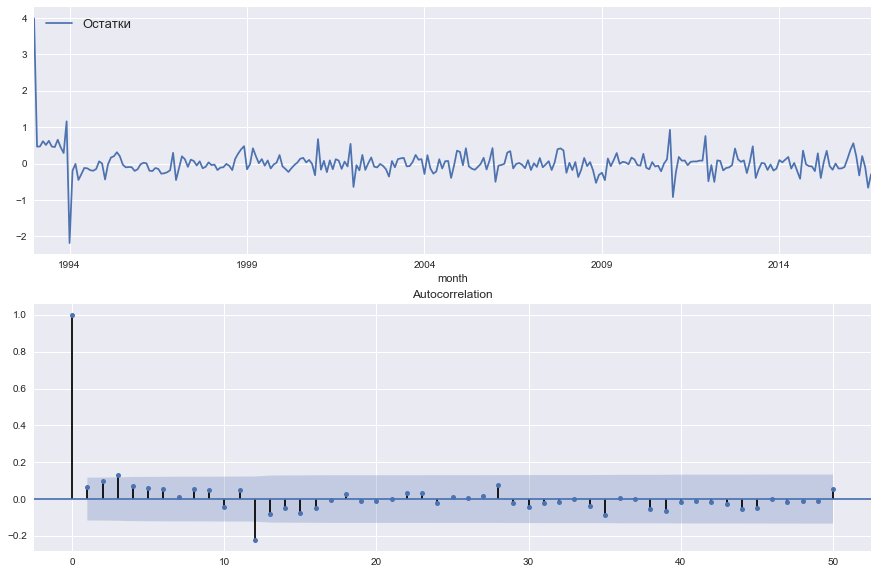

In [12]:
plt.figure(figsize=(15,10))
plt.subplot(211)
best_model.resid.plot()
plt.legend(['Остатки'], fontsize=13, loc='upper left')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid.values.squeeze(), lags=50, ax=ax)

print("Критерий Стьюдента (проверка на несмещенность): p_value = {}".format(stats.ttest_1samp(best_model.resid, 0)[1]))
print("Критерий Дики-Фуллера (проверка на нестационарность): p_value = {}".format(sm.tsa.stattools.adfuller(best_model.resid)[1]))
#print("Критерий Льюнга-Бокса (проверка на автокоррелированность): p_value = {}".format(acorr_ljungbox(list(best_model.resid))[1]))

Остатки в нашем случае:
* не смещены
* стационарны
* не автокоррелированны (похоже, что зависимости от предыдущих значений нет)

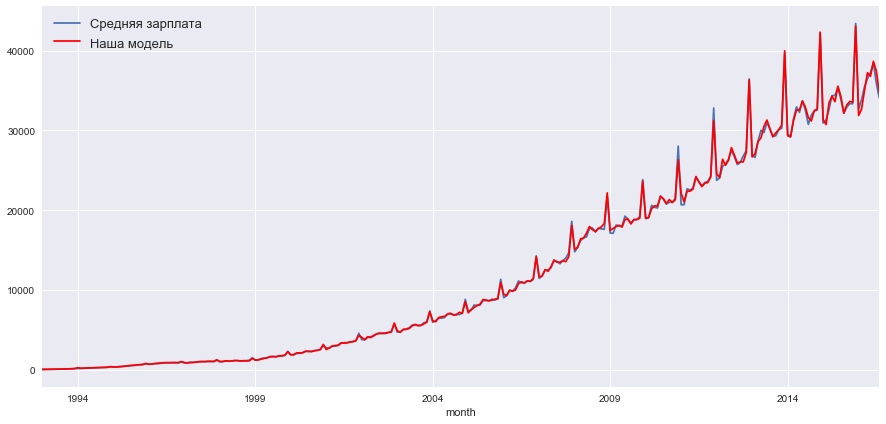

In [13]:
data['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize=(15,7))
data.money.plot()
data.model.plot(color='r')
plt.legend(['Средняя зарплата', 'Наша модель'], fontsize=13, loc='upper left')
plt.show()

## Часть 7. Прогнозирование с помощью финальной модели.

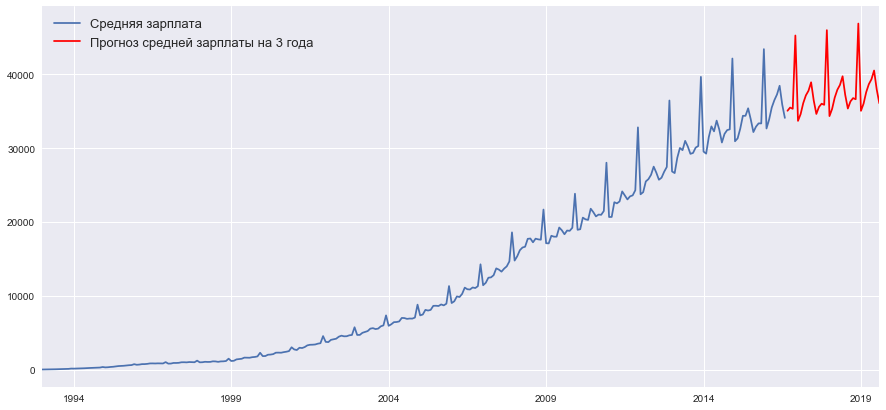

In [14]:
data2 = data[['money']]
date_list = [data.index.max() + relativedelta.relativedelta(months=x) for x in range(1,37)]
future = pd.DataFrame(index=date_list, columns=data2.columns)
data2 = pd.concat([data2, future])
data2['forecast'] = invboxcox(best_model.predict(start=len(data2.index)-36, end=len(data2.index)), lmbda)

plt.figure(figsize=(15,7))
data2.money.plot()
data2.forecast.plot(color='r')
plt.legend(['Средняя зарплата', 'Прогноз средней зарплаты на 3 года'], fontsize=13, loc='upper left')
plt.show()

## Выводы:

Построенный прогноз адекватный, заметен растущий тренд, сезонность не изменилась. Нет каких-либо аномалий.

Так что радуемся 'растущему' уровню жизни, простым моделям и учимся на дата саентиста дальше =)